## Predict Customer Churn Use Case Implementation
The objective is to follow the CRISP-DM methodology to build a model to predict customer churn
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

### Step 1: Connect to Object Storage

We start with connecting to Object Storage. Object Storage is the Bluemix environment for storing flat files. 

The following code has been generated by DSX.

In [1]:
# @hidden_cell
from pyspark.sql import SparkSession

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_78e95108d20b4b6eb7f928636070a5c2(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '985d92f671ed450d8c4a864b0835135f')
    hconf.set(prefix + '.username', '54d76d92adad41e8a2b7c2c24d32b3ce')
    hconf.set(prefix + '.password', 'kb/^on8e8qLWE6~r')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_78e95108d20b4b6eb7f928636070a5c2(name)

spark = SparkSession.builder.getOrCreate()

### Step 2: Load files

In [2]:
# Customer Information
customer = spark.read.format('csv')\
  .options(header='true', inferschema='true')\
  .load('swift://PredictChurn.' + name + '/customer.csv')
  
#Churn information    
customer_churn = spark.read.format('csv')\
  .options(header='true', inferschema='true')\
  .load('swift://PredictChurn.' + name + '/churn.csv')

### Step 3: Merge Files


In [3]:
merged=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])
merged.toPandas().head()

,ID,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


### Step 4: Rename some columns
This step is not a requirement, it just makes some columns names simpler to type with no spaces

In [4]:
merged = merged.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
merged.toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


### Step 5: Data understanding

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and more aggressive business users. The system interprets the language and produces visualizations using the user's choice of existing lower-level visualization technologies typically used by application engineers such as RAVE or D3. 

More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here:  http://brunel.mybluemix.net/gallery_app/renderer

In [5]:
import brunel
Merged = merged.toPandas()
%brunel data('Merged') bar x(CHURN) y(EstIncome) mean(EstIncome) color(LocalBilltype) stack tooltip(EstIncome) | x(LongDistance) y(Usage) point color(Paymethod) tooltip(LongDistance, Usage) :: width=1100, height=400 

<IPython.core.display.Javascript object>

In [6]:
# Heat map
%brunel data('Merged') x(LocalBilltype) y(Dropped) color(#count:red) style('symbol:rect; size:100%; stroke:none') tooltip(Dropped,#count)

<IPython.core.display.Javascript object>

**If you haven't already installed it, run the following cell to install the pixiedust Python library in your notebook environment. Then uncomment it and run it once.**


In [7]:
#!pip install --user --upgrade pixiedust

    100% |████████████████████████████████| 122kB 2.4MB/s 
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s191-4754435a94b541-9fb5ca908bcc/.local/lib/python2.7/site-packages (from pixiedust)
    100% |████████████████████████████████| 6.8MB 178kB/s 
  Running setup.py bdist_wheel for pixiedust ... - \ | / done
  Stored in directory: /gpfs/fs01/user/s191-4754435a94b541-9fb5ca908bcc/.cache/pip/wheels/1c/d2/ee/eeca50b5b09e6783cb3a5caa917129629fc55f2b6e63dcd509
Successfully built pixiedust
  Found existing installation: lxml 3.7.3
    Uninstalling lxml-3.7.3:
      Successfully uninstalled lxml-3.7.3
  Found existing installation: pixiedust 1.0.4
    Uninstalling pixiedust-1.0.4:
      Successfully uninstalled pixiedust-1.0.4



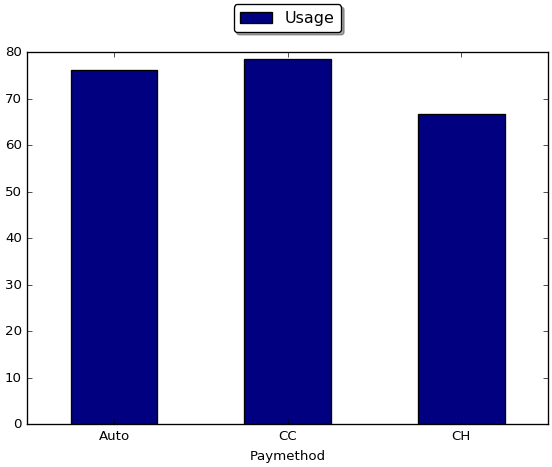

In [8]:
from pixiedust.display import *
display(merged)

In [9]:
# Spark SQL also allow you to use standard SQL
merged.createOrReplaceTempView("merged")
sql = """
SELECT c.*
FROM merged c
WHERE c.EstIncome>90000

"""
spark.sql(sql).toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,61,M,S,2,100020.0,N,50.000000,21.37,0.00,293.24,0,CH,Budget,Standard,314.62,4,T
1,79,F,S,0,98716.3,N,55.660000,20.97,8.23,13.92,0,CC,FreeLocal,Standard,43.13,4,T
2,87,M,M,1,97180.4,N,50.600000,8.21,9.63,45.66,0,CC,FreeLocal,Standard,63.51,4,T
3,109,M,S,1,92647.5,N,56.046667,16.04,5.74,10.34,0,CC,Budget,Standard,32.13,4,T
4,148,M,M,2,91272.2,Y,25.033333,26.99,0.00,13.01,0,CC,FreeLocal,Standard,40.00,3,F


### Step 6: Build the Spark pipeline and the Random Forest Classifier model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: http://spark.apache.org/docs/latest/ml-guide.html

In [10]:
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
stringIndexer1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
stringIndexer2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
stringIndexer3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
stringIndexer4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
stringIndexer5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
stringIndexer6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')
stringIndexer7 = StringIndexer(inputCol='CHURN', outputCol='label')

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", \
                                       "LongDistanceBilltypeEncoded", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan"], outputCol="features")


# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

#pipeline = Pipeline(stages=[stringIndexer1, stringIndexer2, stringIndexer3, assembler, rf])
pipeline = Pipeline(stages=[stringIndexer1,stringIndexer2,stringIndexer3,stringIndexer4,stringIndexer5,stringIndexer6,stringIndexer7, assembler, rf])


In [11]:
# Split data into train and test datasets
(trainingData, testingData) = merged.randomSplit([0.7, 0.3],seed=9)
trainingData.cache()
testingData.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: double, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: double, CHURN: string]

In [12]:
# Build model
model = pipeline.fit(trainingData)

### Step 7: Score the test data set

In [13]:
result=model.transform(testingData)
result_display=result.select(result["ID"],result["CHURN"],result["Label"],result["prediction"],result["probability"])
result_display.toPandas().head(6)

,ID,CHURN,Label,prediction,probability
0,1,T,1,1,"[0.0390066830438, 0.960993316956]"
1,18,F,0,0,"[0.604568153513, 0.395431846487]"
2,22,F,0,0,"[0.743416529489, 0.256583470511]"
3,23,F,0,0,"[0.92480094066, 0.0751990593396]"
4,29,T,1,1,"[0.134435036135, 0.865564963865]"
5,40,T,1,1,"[0.222010772111, 0.777989227889]"


### Step 8: Model Evaluation
Find accuracy of the models and the Area Under the ROC Curve 

In [14]:
print 'Model Accuracy = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))

Model Accuracy = 0.92.


In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(result))

Area under ROC curve = 0.91.


###  Step 9:  Tune the model to find the best model

#### Build a Parameter Grid specifying the parameters to be evaluated to determine the best combination

In [16]:
# set different levels for the maxDepth
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth,[4,6,8]).build())

#### Create a cross validator to tune the pipeline with the generated parameter grid
Cross-validation attempts to fit the underlying estimator with user-specified combinations of parameters, cross-evaluate the fitted models, and output the best one.

In [17]:
# perform 3 fold cross validation
cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(3)

In [18]:
# train the model
cvModel = cv.fit(trainingData)

# pick the best model
best_rfModel = cvModel.bestModel

# score the test data set
cvresult=best_rfModel.transform(testingData)

In [19]:

print 'Model Accuracy of the best fitted model = {:.2f}.'.format(cvresult.filter(cvresult.label == cvresult.prediction).count()/ float(cvresult.count()))
print 'Model Accuracy of the default model = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))
print '   '
print('Area under the ROC curve of best fitted model = {:.2f}.'.format(evaluator.evaluate(cvresult)))
print 'Area under the ROC curve of the default model = {:.2f}.'.format(evaluator.evaluate(result))

Model Accuracy of the best fitted model = 0.97.
Model Accuracy of the default model = 0.92.
   
Area under the ROC curve of best fitted model = 0.96.
Area under the ROC curve of the default model = 0.91.


### Step 10: Save Model
Save the best model in Object Storage. 

A separate notebook has been created for "batch scoring deployment". This deployment notebook retrieves the model from object storage and applies it to a new dataset. The notebook can be scheduled to run via the Notebook scheduler (the clock icon on the menu bar) or through the deployment interface in IBM ML (currently in beta).

In [20]:
# Overwrite any existing saved model in the specified path
best_rfModel.write().overwrite().save("PredictChurn.churnModel")

You have come to the end of this notebook

**Sidney Phoon**<br/>
yfphoon@us.ibm.com <br/>
May 4th, 2017